In [46]:
import pandas as pd
import requests 
import seaborn as  sns
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlencode 
import math

# Проект: вариант 2

## Задание 1. A/B–тестирование

Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [47]:
def parse_from_yandex_drive(link):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = link 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    download_response = requests.get(download_url)
    return download_url

In [48]:
# датафрейм с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, 
# B – целевая группа) 
groups = pd.read_csv(parse_from_yandex_drive('https://disk.yandex.ru/d/41q4bLBeeJocVg'), sep=';')
groups = groups.rename(columns={'id':'student_id'})
groups.head(1)

,student_id,grp
0,1489,B


In [49]:
# дополнительный датафрейм с пользователями, который был прислан спустя 2 дня после передачи данных
groups_add = pd.read_csv(parse_from_yandex_drive('https://disk.yandex.ru/d/-Z9Q12eDWnP8wA'), sep=',')
groups_add = groups_add.rename(columns={'id':'student_id'})
groups_add.head(1)

,student_id,grp
0,5694584,B


In [50]:
# датафрейм с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
active_studs = pd.read_csv(parse_from_yandex_drive('https://disk.yandex.ru/d/pdYvInDms1MZng'))
active_studs.head(1)

,student_id
0,581585


In [51]:
# датафрейм с информацией об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv(parse_from_yandex_drive('https://disk.yandex.ru/d/JgIlJcyuoYHWIg'), sep=';')
checks.head(1)

,student_id,rev
0,1627,990.0


### Исследование на пользователей сделавших покупку, но не учавствующих в эксперименте.

In [52]:
count_non_active_studs_with_check = len([i for i in checks.student_id.unique() if  i not in active_studs.student_id.unique()])

In [53]:
count_non_active_studs_with_check

149

#### Количество студентов совершивших покупку, но не участвующих в эксперименте  равно 149

In [54]:
# собираем старый и новые файлы с принадлежностью пользователей
merge_df = pd.concat([groups, groups_add], ignore_index=True) 

In [55]:
# создаем новую колонку, в которой будет указано: заходил ли пользователь в дни проведения эксперимента
merge_df['active_status'] = ['yes' if i in active_studs.student_id.unique() else 'no' for i in merge_df.student_id]

In [56]:
# для каждого пользователя получаем колонку с потраченной суммой
final_data = pd.merge(merge_df, checks, on = 'student_id', how='left')

In [57]:
# создаем новую колонку, в которой будет указано: потратил ли пользователь деньги
final_data['pay_status'] = ['non_payed' if math.isnan(i)  else 'payed' for i in final_data['rev']]

In [58]:
final_data = final_data.rename(columns={'rev': 'pay_size'})

In [59]:
# оставляем только тех пользователей, которые участвовали в эксперименте
selection_by_visit = final_data.query('active_status == "yes"')

### Статистический анализ

#### Первичная проверка на эффективность 

1. Выявляем размер среднего чека для каждой группы

In [60]:
group_sum = selection_by_visit.groupby('grp').agg({'pay_size': 'sum', 'student_id': 'count'}).reset_index()
group_sum['mean_check'] = group_sum['pay_size'] / group_sum['student_id']
group_sum[['grp', 'mean_check']]

,grp,mean_check
0,A,47.347204
1,B,58.058798


In [61]:
group_sum

,grp,pay_size,student_id,mean_check
0,A,72820.0000,1538,47.347204
1,B,394974.0035,6803,58.058798


##### *** обращаю внимание, что в группе "А" в 4.5 раза меньше пользователей, чем в группе "B"

2. Смотрим процентное распределение покупателей и обычных пользователей

In [62]:
selection_by_visit.query('grp == "A"').pay_status.value_counts(normalize=True).mul(100)

pay_status
non_payed    94.928479
payed         5.071521
Name: proportion, dtype: float64

In [63]:
selection_by_visit.query('grp == "B"').pay_status.value_counts(normalize=True).mul(100)

pay_status
non_payed    95.384389
payed         4.615611
Name: proportion, dtype: float64

##### ВЫВОД: 
Первичная проверка на эффективность новой механики оплаты показала, разницу между тестируемыми группами. А именно:
у группы "А" процент покупающих пользователей - выше. У группы "B" выше средний чек.

##### Проверка на нормальность распределения с помощью теста Шапиро-Уилка

In [64]:
selected_data = selection_by_visit.copy()

# Заменяем значения NaN в столбце 'pay_size' на 0
selected_data['pay_size'] = selected_data['pay_size'].fillna(0)


In [65]:
selected_data.head(1)

,student_id,grp,active_status,pay_size,pay_status
1,1627,A,yes,990.0,payed


In [66]:
a_shapiro = sp.stats.shapiro(selected_data.query('grp == "A" and pay_size != 0.0').pay_size)
a_shapiro

ShapiroResult(statistic=0.7353236442181668, pvalue=1.49869203824321e-10)

In [67]:
b_shapiro = sp.stats.shapiro(selected_data.query('grp == "B" and pay_size != 0.0').pay_size)
b_shapiro

ShapiroResult(statistic=0.8547218120137667, pvalue=1.5433362141142128e-16)

##### Строим графики для демонстрации распределений стоимости покупок

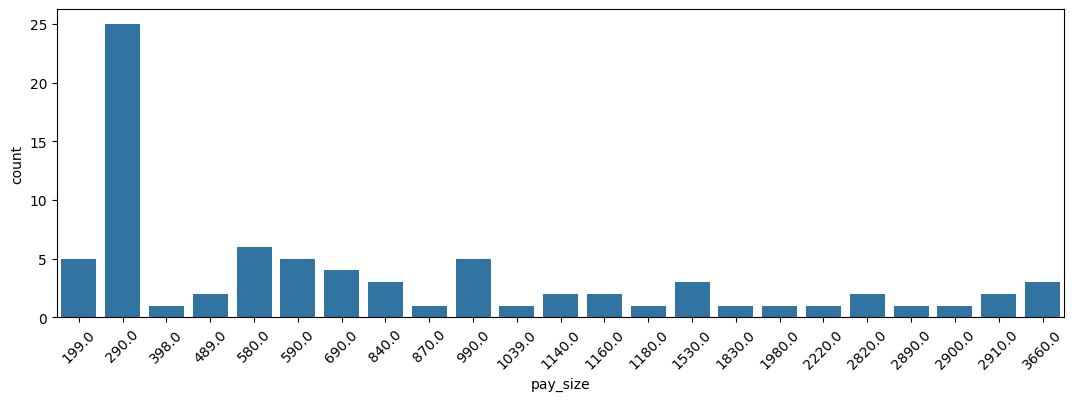

In [68]:
plt.figure(figsize=(13,4))
plt.xticks(rotation=45)
sns.countplot(data=selected_data.query('grp == "A" and pay_size != 0.0'),  x='pay_size')
plt.show()

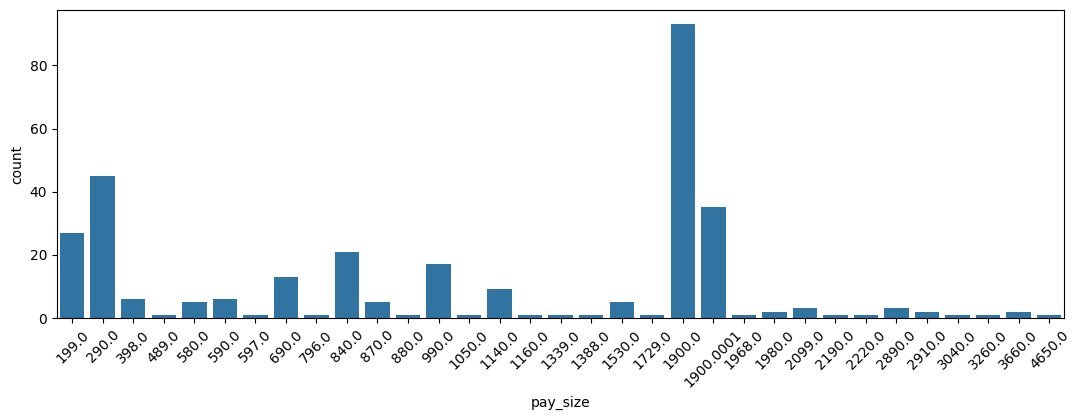

In [69]:
plt.figure(figsize=(13,4))
plt.xticks(rotation=45)
sns.countplot(data=selected_data.query('grp == "B" and pay_size != 0.0'),  x='pay_size')
plt.show()

Вывод: данные не распределены нормально. t-критерий Стьюдента нам не подходит



"""



### Поэтому используем Критерий Колмогорова Смирнова

##### Формирование гипотез
     H0: Средние чеки статистически значимо не различаются.
     H1: Средние чеки статистически значимо различаются.
    

In [70]:
selected_data_for_colmsmirn = selected_data.groupby('grp').agg({'pay_size': 'mean'}).reset_index()
selected_data_for_colmsmirn

,grp,pay_size
0,A,47.347204
1,B,58.058798


In [71]:
statistic, p_value = sp.stats.ks_2samp(selected_data.query('grp == "A"').pay_size, selected_data.query('grp == "B"').pay_size)

In [72]:
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: Средние чеки статистически значимо различаются.")
else:
    print("Не удалось отвергнуть нулевую гипотезу: Средние чеки статистически значимо не различаются.")

Не удалось отвергнуть нулевую гипотезу: Средние чеки статистически значимо не различаются.


## Используем bootstrap для стат теста ARPPU

##### Формирование гипотез
     H0: ARPPU статистически значимо не различается.
     H1: ARPPU статистически значимо различается.
    

In [73]:
boots_arppu_df = selected_data.copy()
boots_arppu_df['pay_size'] = boots_arppu_df['pay_size'].fillna(0)
boots_arppu_df.head(1)

,student_id,grp,active_status,pay_size,pay_status
1,1627,A,yes,990.0,payed


Мы уже выяснили, что распределения неравномерны, но для наглядности построим график

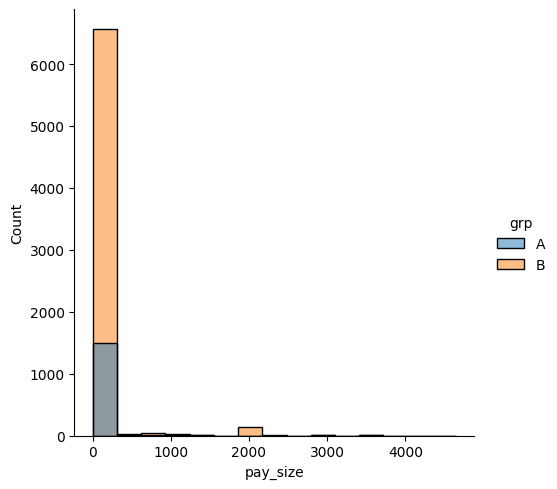

In [74]:
sns.displot(data=boots_arppu_df, x='pay_size', hue='grp')

In [85]:
# напишем функцию для подсчета ARPPU по методу Bootstrap

def count_arppu(df, n = 10000):
    array_for_arppu = []
    for i in range(n):
        sample_data = df.sample(frac=1, replace=True)
        sample_arppu = sample_data.pay_size.sum() / sample_data.student_id.nunique()
        array_for_arppu.append(sample_arppu)
    new_df = pd.DataFrame({'arppu': array_for_arppu})
    return new_df

In [76]:
# Применим функцию
a_group_arppu = count_arppu(boots_arppu_df.query('grp == "A" and pay_status == "payed"'))
b_group_arppu = count_arppu(boots_arppu_df.query('grp == "B" and pay_status == "payed"'))

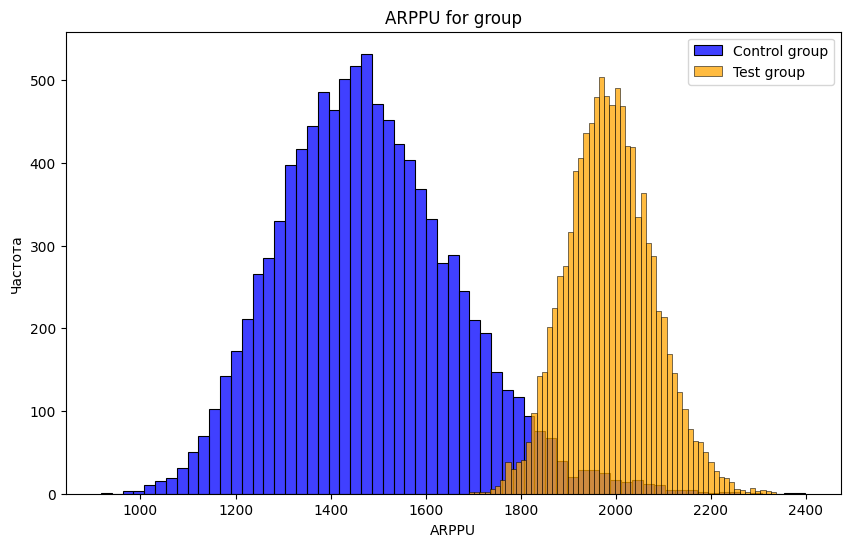

In [77]:
# Построение графика распределения ARPPU для каждой группы
plt.figure(figsize=(10, 6))
sns.histplot(a_group_arppu['arppu'], label='Control group',  color='blue')
sns.histplot(b_group_arppu['arppu'], label='Test group',  color='orange')
plt.title('ARPPU for group')
plt.xlabel('ARPPU')
plt.ylabel('Частота')
plt.legend()
plt.show()

##### Теперь наши распределения похожи на нормальные

In [78]:
# напишем функцию для построения доверительного интервала

def bootstrap_confidence_interval(data, alpha=0.05, n=10000):
    array_for_means = []
    for i in range(n):
        sample = np.random.choice(data, len(data), replace=True)
        array_for_means.append(np.mean(sample))
    lower_bound = np.percentile(array_for_means, 100 * alpha / 2)
    upper_bound = np.percentile(array_for_means, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

In [79]:
# Рассчитываем доверительные интервалы для каждой группы

a_group_ci = bootstrap_confidence_interval(a_group_arppu['arppu'])
b_group_ci = bootstrap_confidence_interval(b_group_arppu['arppu'])

print("Группа A CI:", a_group_ci)
print("Группа B CI:", b_group_ci)

Группа A CI: (1475.6341893557294, 1482.6930484260163)
Группа B CI: (1986.3450922870843, 1989.8814799223203)


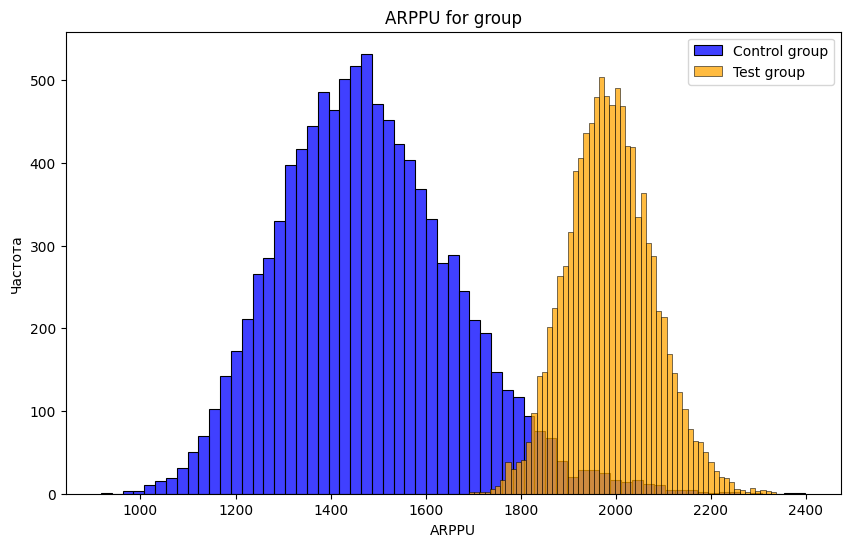

In [80]:
# Построение графика распределения ARPPU для каждой группы
plt.figure(figsize=(10, 6))
sns.histplot(a_group_arppu['arppu'], label='Control group',  color='blue')
sns.histplot(b_group_arppu['arppu'], label='Test group',  color='orange')
plt.title('ARPPU for group')
plt.xlabel('ARPPU')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [81]:
# Проверка статистической значимости
if a_group_ci[1] < b_group_ci[0] or a_group_ci[0] > b_group_ci[1]:
    print("Отвергаем нулевую гипотезу: ARPPU статистически значимо различается.")
else:
    print("Не удалось отвергнуть нулевую гипотезу: ARPPU статистически значимо не различается.")

Отвергаем нулевую гипотезу: ARPPU статистически значимо различается.


#### Вывод: различия ARPPU статистически значимы. Отклоняем нулевую гипотезу.

### Используем тест хи-квадрат чтобы выяснить: есть ли существенная разница в процентном соотношении покупателей к обычным пользователям, для каждой группы. 

##### Формирование гипотез
     H0: Проведенный эксперимент показал, что эффекта нет. Соотношение покупателей к обычным пользователямчеков статистически не существенно.
     H1: Проведенный эксперимент показал, что эффект есть. Соотношение покупателей к обычным пользователямчеков статистически существенно.

In [82]:
stat, p, dof, expected = sp.stats.chi2_contingency(pd.crosstab(selection_by_visit.pay_status, selection_by_visit.grp))

In [83]:
print(f"Статистика хи-квадрат: {stat}")
print(f"p-value: {p}")

Статистика хи-квадрат: 0.48480826522557896
p-value: 0.48625240457231045


In [84]:
prob = 0.95
critical = sp.stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


#### Вывод: существенной разницы не выявлено. Мы не можем отклонить H0 гипотезу.

"""
## Итоги и выводы всей работы

1. В ходе анализа я оценивал метрики стоимости услуг и соотношение активных пользователей(клиентов) и пассивных пользователей, так как они наиболее точным образом могут рассказать о успешности новой механики.


2.   
    
    2.1 Для тестируемой группы имеются незначительные изменения конверции пользователя в покупателя, в отрицательную сторону(!). Данное изменение может быть связано с тем, что новая механика оплаты не всем удобна и некоторые пользователи могу отказываться от покупки в момент непосредственного взаимодействия с ней.
    
    2.2 Но при этом есть значительные улучшения показателя средний чек, примерно на 20%. Данное изменение может быть связано с тем, что при переходе на страницу оплаты, пользователям предлагется докупить какие-то дополнительные товары. Либо в дни тестирования проводилась какая-то рекламная кампания, отчего продажи выросли.

    
3. Тесты показали, что изменения из пунктов 2.1 и 2.2 не являются статистически значимым.


4. Тесты показали, что значение ARPPU является статистически значимым.


5. Считаю, что проведенный анализ не может дать полных оснований утверждать, что новую механику оплаты стоит внедрить на всех пользователей. Возможно стоит посмотреть: что служит причиной/причинами для уменьшения конверции пользователя в покупателя. Увеличение чека конечно может служить аргументов за внедрение новой механики, но нужно учитывать: не было ли на сайте, в дни проведения эксперимента, еще каких-то изменений. Не проводились ли рекламные кампании. Не выпали ли дни проведения эксперимента на какие-то праздники, когда люди склонны тратить больше итд. Так же в тестируемой группе в 4,5 раза больше пользователей, чем в контрольной. Это тоже может влиять на финальный итог. В общем для однозначного ответа хотелось бы иметь больше информации. 
   Однако, ориентируясь на тест различий ARPPU, можно сказать что новая механика оплаты успешна и ее можно применить на всех пользователей